In [1]:
# Imports 
global N_atoms, atoms, atom_coordinates, STOnG, B, N
import numpy as np
from numpy import *
import scipy
from scipy.special import erf
import hftools as hft

In [2]:
import hftools as hft

In [3]:
xyz='''2

He 0 0 0
H  0 0 1.4632'''

In [4]:
N_atoms, atoms, atom_coordinates = hft.xyz_reader(xyz)

In [5]:
from initialize import *

In [6]:


STOnG = 3

# Basis set size
B = 0
for atom in atoms:
    B += max_quantum_number[atom]
    
# Other book-keeping

# Number of electrons (Important!!)
N = 2


In [7]:
S,T,V,multi_electron_tensor,gcfl = hft.calculate_integrals(zeta_dict, max_quantum_number, \
                                                      D, alpha, charge_dict, N_atoms, \
                                                      atoms, atom_coordinates, STOnG, B, N)

a1=gcfl[0]['He'][0]
a2=gcfl[1]['H'][0]
dvec=gcfl[0]['He'][1]

X = hft.orthoganalize_basis(S)

Hcore = T + V

In [8]:
print(gcfl)

[{'He': [array([0.48084429, 1.77669115, 9.75393462]), array([0.444635, 0.535328, 0.154329])]}, {'H': [array([0.16885616, 0.62391349, 3.42525002]), array([0.444635, 0.535328, 0.154329])]}]


iteration 1 Total SCF Energy 0.0 a.u.
iteration 2 Total SCF Energy -4.141860256587707 a.u.
iteration 3 Total SCF Energy -4.226488469192394 a.u.
iteration 4 Total SCF Energy -4.227519478882532 a.u.
iteration 5 Total SCF Energy -4.227525821517997 a.u.
iteration 6 Total SCF Energy -4.227525857431003 a.u.


STO3G Restricted Closed Shell HF algorithm took 6 iterations to converge


The orbital energies are -1.5974477442856962 and -0.06166952037286738 Hartrees


The orbital matrix is: 

[[-0.80191685  0.78226417]
 [-0.33680061 -1.0684443 ]]


The density/bond order matrix is: 

[[1.28614127 0.54017217]
 [0.54017217 0.22686931]]


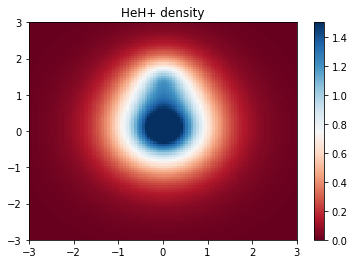

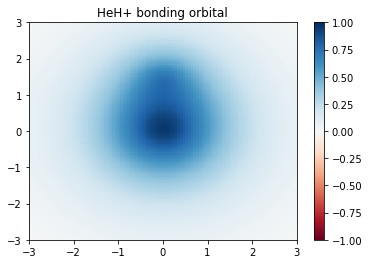

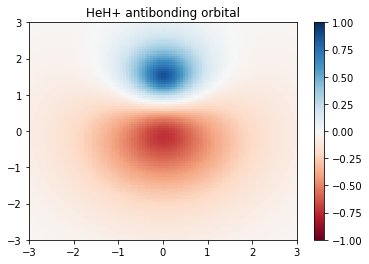

In [9]:
# Algorithm

# Initial guess at P
P = np.zeros((B,B))
P_previous = np.zeros((B,B))
P_list = []

# Iterative process
threshold = 100
counter = 1
while threshold > 10**-4:
    
    # Calculate Fock matrix with guess
    G = np.zeros((B,B))
    for i in range(B):
        for j in range(B):
            for x in range(B):
                for y in range(B):
                    G[i,j] += P[x,y]*(multi_electron_tensor[i,j,y,x]-0.5*multi_electron_tensor[i,x,y,j])    
    Fock = Hcore + G


    C, orbital_energies = hft.get_coeffs_and_eigenvalues(Fock,X)

    # Form new P (note, we only sum over electron pairs - we DON'T sum
    # over the entire basis set.
    E0=0
    for i in range(B):
        for j in range(B): 
            E0 += P[i,j]*(Hcore[i,j] + Fock[i,j])
    E0 = 0.5*E0
    
    print("iteration "+str(counter) + " Total SCF Energy " +str(E0) + " a.u.")
    
    #
    for i in range(B):
        for j in range(B):
            for a in range(int(N/2)):
                P[i,j] = 2*C[i,a]*C[j,a]
                
                
    P_list.append(P)

    threshold = hft.SD_successive_density_matrix_elements(P_previous,P,B)
    P_previous = P.copy()
    counter +=1
print('\n')
print('STO3G Restricted Closed Shell HF algorithm took {} iterations to converge'.format(len(P_list)))
print('\n')
print('The orbital energies are {} and {} Hartrees'.format(orbital_energies[0],orbital_energies[1]))
print('\n')
print(f'The orbital matrix is: \n\n{C}')
print('\n')
print(f'The density/bond order matrix is: \n\n{P}')

Ra = atom_coordinates[0]
Rb = atom_coordinates[1]
hft.plot_dens(a1,a2,dvec,Ra,Rb,P)
hft.plot_orb_bond(a1,a2,dvec,Ra,Rb,C)
hft.plot_orb_antibond(a1,a2,dvec,Ra,Rb,C)
#print(C)